In [18]:
"""Extract unique gene sequence shingles, from only ecoli"""

'Extract unique gene sequence shingles, from only ecoli'

In [19]:
!pip install biopython

In [0]:
import os
import re
import gzip
import pickle
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable

import torch

In [21]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [23]:
# load fasta sequence
d = "drive/My Drive/Colab Notebooks/smaug/data/ecoli_MG1655"
genome_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.fna.gz")

with gzip.open(genome_path, 'rt') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = record.seq

# get gene locations
gbff_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.gbff.gz")
gene_loc_list, gene_seq_list = get_CDS_locations(gbff_path)

# total genes and example loc
print(len(gene_loc_list))
print(gene_loc_list[300])

3532
[381350:381716](+)


In [24]:
# format genes correctly
gene_aa = [x.translate(table=11, to_stop=False) for x in gene_seq_list]
gene_aa_filtered = [x[1:-1][::-1] for x in gene_aa if (x[-1] == "*")] # cut off start and stop codons, and reverse (strand should be 3' to 5' for model)

/usr/local/lib/python3.6/dist-packages/Bio/Seq.py:2748: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [0]:
def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":-1, # get rid of these
             "B":-1,
             "*":-1}
    tokenized = torch.tensor([table[aa] for aa in aa_seq], dtype=int)
    if not -1 in tokenized and len(tokenized) == 20: ################################ note length filter here
        return True, tokenized
    else:
        return False, tokenized

(array([1.552e+03, 1.419e+03, 3.770e+02, 1.130e+02, 2.900e+01, 1.700e+01,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  12. ,  246.5,  481. ,  715.5,  950. , 1184.5, 1419. , 1653.5,
        1888. , 2122.5, 2357. ]),
 <a list of 10 Patch objects>)

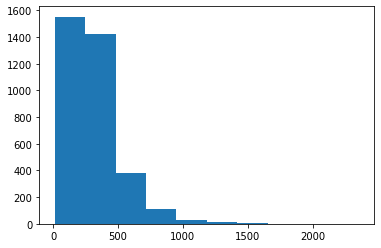

In [27]:
import matplotlib.pyplot as plt
lens = [len(x) for x in gene_aa_filtered]
plt.hist(lens)

In [14]:
# split long ORFs into shingles, 3' to 5' (very important to get correct direction)

SHINGLE_STEP = 20
SHINGLE_LENGTH = 20

ORF_shingled = []
for i, ORFseq in enumerate(gene_aa_filtered):
    if i%1000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        valid, shingle_int = tokenize_aa_seq(shingle)
        if valid:
            ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    valid, shingle_int =  tokenize_aa_seq(shingle_last)
    if valid:
        ORF_shingled_temp.append(shingle_int)
    ORF_shingled.append(ORF_shingled_temp)

0
1000
2000
3000


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
ORF_shingled_clean = [x for x in ORF_shingled if not x == []]
combined = [torch.stack(x, dim=0) for x in ORF_shingled_clean]
combined_shape = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [0]:
# shuffle
subset = np.unique(combined_flat, axis=0)

np.random.seed(2019)
np.random.shuffle(subset)

In [0]:
# save
d = "drive/My Drive/Colab Notebooks/smaug/data"
shingle_path = os.path.join(d, "ecoli_MG1655_shingles_length20_overlap10.npy")

with open(shingle_path, 'wb') as f:
    np.save(shingle_path, subset)